In [23]:
%pip install --upgrade anomalytics
%pip list

Note: you may need to restart the kernel to use updated packages.
Package                   Version
------------------------- ------------
anomalytics               0.1.2
anyio                     4.1.0
appnope                   0.1.3
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.13.1
beautifulsoup4            4.12.2
bleach                    6.1.0
blinker                   1.7.0
boto3                     1.33.6
botocore                  1.33.6
Brotli                    1.1.0
cached-property           1.5.2
certifi                   2023.11.17
cffi                      1.16.0
charset-normalizer        3.3.2
click                     8.1.7
cloudpickle               3.0.0
colorama                  0.4.6
comm                      0.1.4
contourpy                 1.2.0
cycler                    0.12.1
debugpy        

In [24]:
import anomalytics as atics
import matplotlib.pyplot as plt

plt.style.use("bmh")

<h1 align=center><strong>Example - Anomaly Detection with POT Method</strong></h1>

The dataset used here is downloaded from [pyextremes](https://georgebv.github.io/pyextremes/quickstart/). The data is based on water level data for ["The Battery" station](https://tidesandcurrents.noaa.gov/waterlevels.html?id=8518750) located in New York, as stated in the webpage.

Now, we are going to analyse this dataset as an example project for using `anomalytics`.

# **The Data**

In the current release `v0.1.0`,  I decided to start analysing Time Series which is a `pandas.Series` object since to analysie `pandas.DataFrame`, we can easily decoouple each feature and run a single analysis. Hence as the first step, let#s upload the data with the built-in wrapper function from `anomalyitcs`.

In [25]:
ts = atics.read_ts(
    path_to_file="./assets/battery_wl.csv",
    file_type="csv",
    names=["Water Level"]
)
ts.head()

2008-11-03 06:00:00    0.219
2008-11-03 07:00:00   -0.041
2008-11-03 08:00:00   -0.282
2008-11-03 09:00:00   -0.368
2008-11-03 10:00:00   -0.400
Name: Water Level, dtype: float64

# **The EDA**

In [26]:
ts.describe()

count    100002.000000
mean          0.029332
std           0.546171
min          -1.856000
25%          -0.423000
50%           0.035000
75%           0.483000
max           3.417000
Name: Water Level, dtype: float64

In [27]:
ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 100002 entries, 2008-11-03 06:00:00 to 2020-03-31 23:00:00
Series name: Water Level
Non-Null Count   Dtype  
--------------   -----  
100002 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


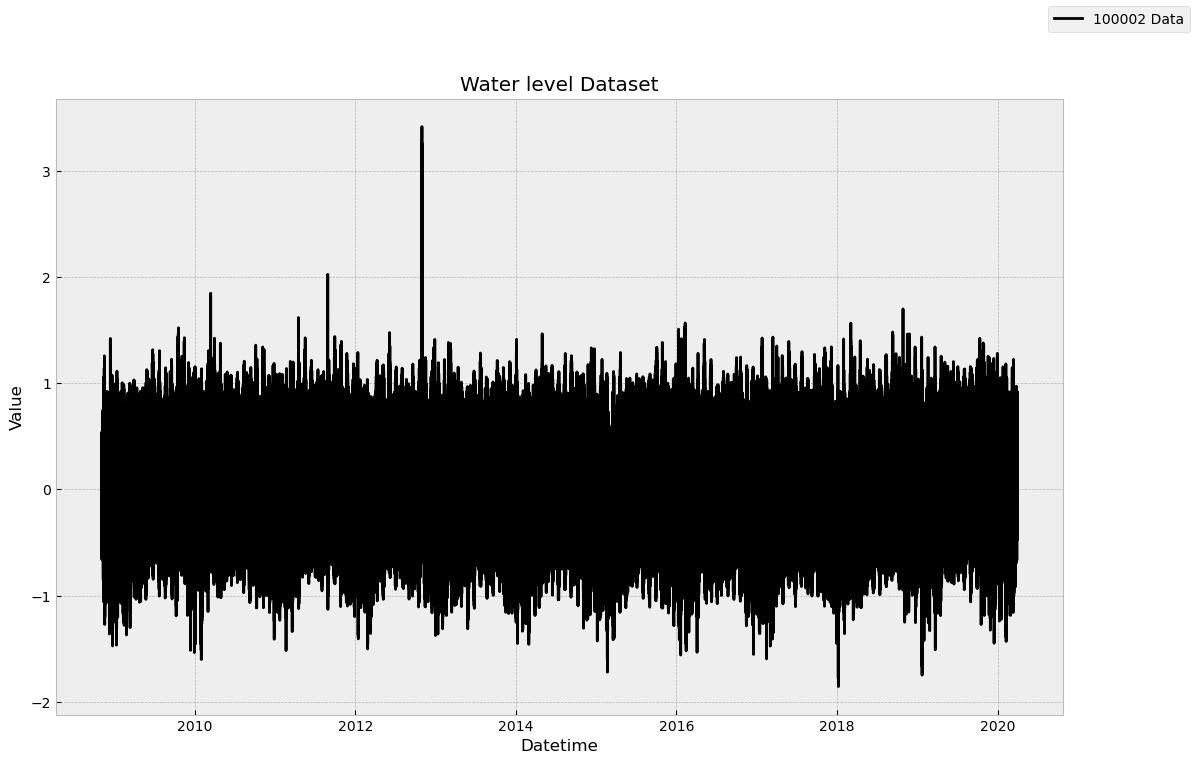

In [28]:
fig = plt.figure(figsize=(13, 8))
plt.plot(ts.index, ts.values, color="black", alpha=1, label=f"{ts.shape[0]} Data")
plt.title(f"{ts.name.capitalize()} Dataset")
plt.xlabel("Datetime")
plt.ylabel("Value")
fig.legend()
plt.show()

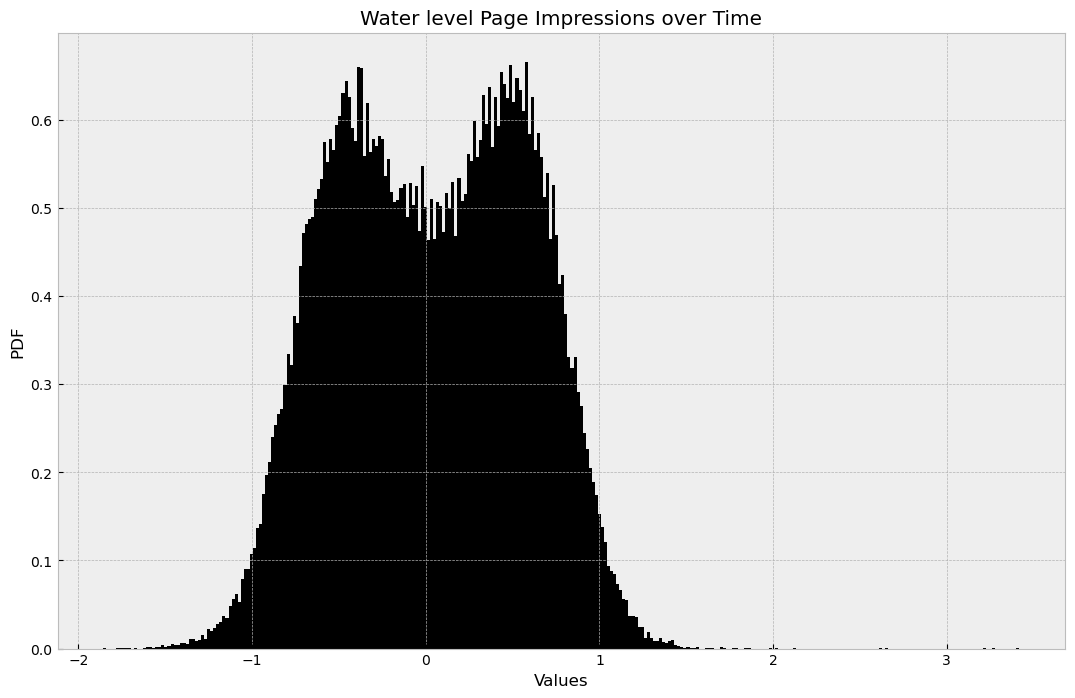

In [29]:
fig = plt.figure(figsize=(13, 8))
plt.hist(ts.values, bins=300, density=True, color="black", alpha=1)
plt.title(f"{ts.name.capitalize()} Page Impressions over Time")
plt.ylabel("PDF")
plt.xlabel("Values")
plt.show()

# **The Detector**

To analyse this data, we are going to apply Peaks Over Threshold method to extract the exceedances and fit it to Generalized Pareto Distribution so we can calculate the anomaly score which is basically just. The idea is to have every statistical method and create a model out of it so we can choose based on the use case. Currently, I  have just implemented the POT Method. Hence the `POT Detector` 😎

In [30]:
pot_detector = atics.get_detector(
    method="POT",
    dataset=ts,
    anomaly_type="high"
)
str(pot_detector)

'POT'

In [31]:
#Reset time windows
pot_detector.reset_time_window(
    analysis_type="historical",
    t0_pct=0.65,
    t1_pct=0.25,
    t2_pct=0.1
)

In [32]:
print("T0:", pot_detector.t0)
print("T1:", pot_detector.t1)
print("T2:", pot_detector.t2)

T0: 65001
T1: 25001
T2: 10000


# **The Peaks Over Threshold**

In [33]:
pot_detector.get_extremes(q=0.99)
pot_detector.exceedance_thresholds.head(20)

2008-11-03 06:00:00    1.084
2008-11-03 07:00:00    1.084
2008-11-03 08:00:00    1.084
2008-11-03 09:00:00    1.084
2008-11-03 10:00:00    1.084
2008-11-03 11:00:00    1.084
2008-11-03 12:00:00    1.084
2008-11-03 13:00:00    1.084
2008-11-03 14:00:00    1.084
2008-11-03 15:00:00    1.084
2008-11-03 16:00:00    1.084
2008-11-03 17:00:00    1.084
2008-11-03 18:00:00    1.084
2008-11-03 19:00:00    1.084
2008-11-03 20:00:00    1.084
2008-11-03 21:00:00    1.084
2008-11-03 22:00:00    1.084
2008-11-03 23:00:00    1.084
2008-11-04 00:00:00    1.084
2008-11-04 01:00:00    1.084
Name: Water Level, dtype: float64

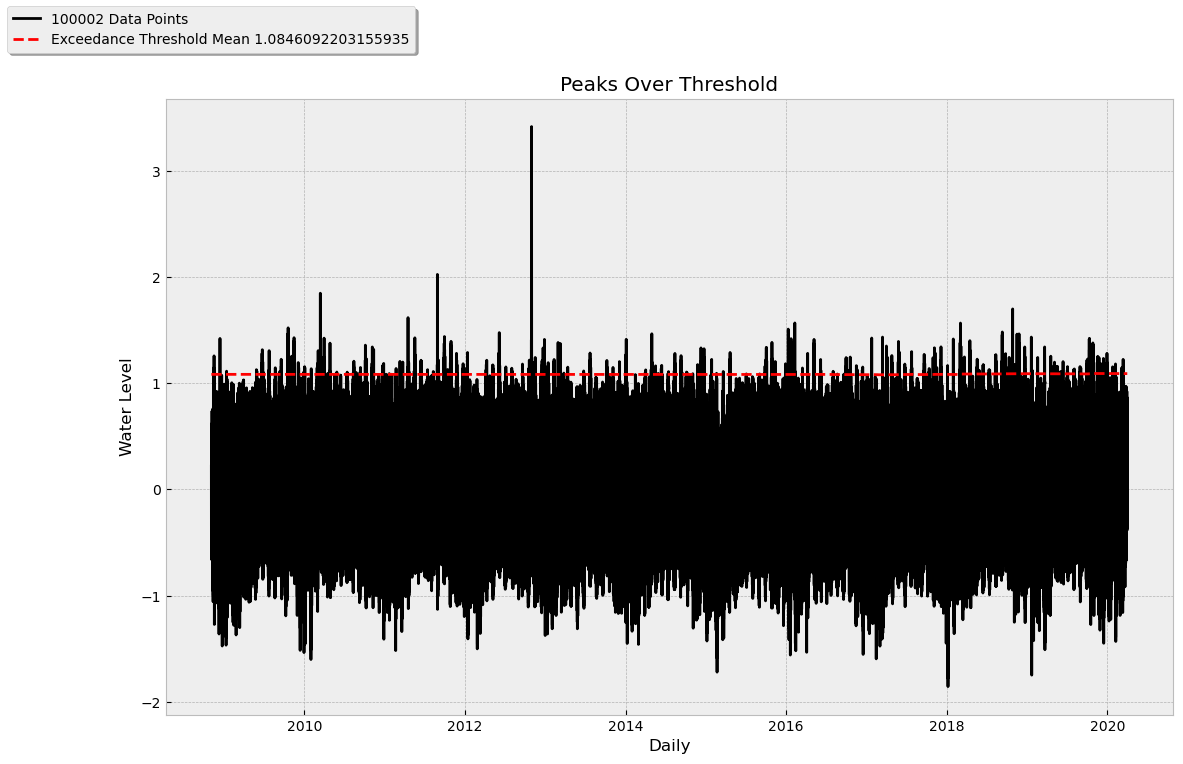

In [34]:
pot_detector.plot(plot_type="l+eth", title=f"Peaks Over Threshold", xlabel="Daily", ylabel="Water Level", alpha=1.0)

In [35]:
pot_detector.exceedances[pot_detector.exceedances.values != 0.0].tail()

2020-03-07 11:00:00    0.05600
2020-03-08 11:00:00    0.01237
2020-03-08 12:00:00    0.05200
2020-03-13 03:00:00    0.01700
2020-03-13 04:00:00    0.13300
Name: exceedances, dtype: float64

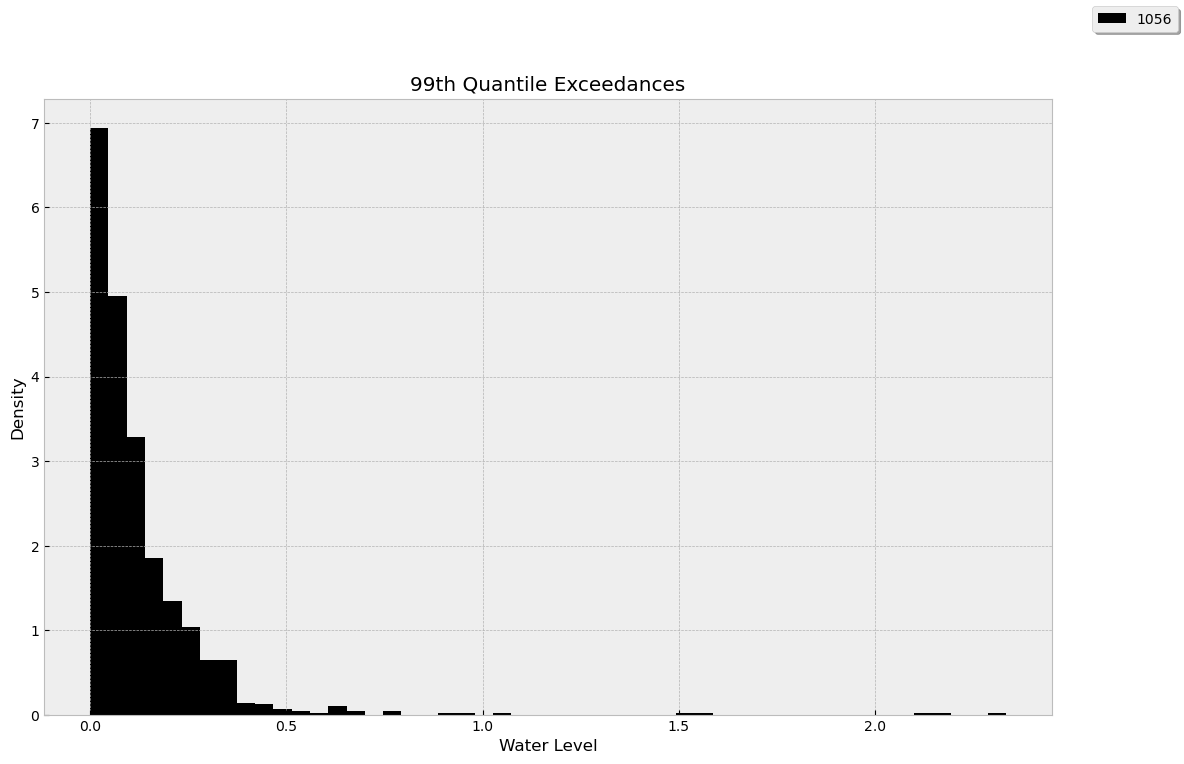

In [36]:
pot_detector.plot(plot_type="gpd", title="99th Quantile Exceedances", xlabel="Water Level", ylabel="Density", alpha=1.0)

# **The Anomaly Score**

The anomaly score is the inverted value which is calculated as follow:

$\text{inverted p-value}=1 / (1-CDF(data, c, loc, scale))$

The idea of the inversion is to give the intuition of how big the score is. 

In [37]:
pot_detector.fit()
pot_detector.fit_result.head(20)

2016-04-03 15:00:00    0.0
2016-04-03 16:00:00    0.0
2016-04-03 17:00:00    0.0
2016-04-03 18:00:00    0.0
2016-04-03 19:00:00    0.0
2016-04-03 20:00:00    0.0
2016-04-03 21:00:00    0.0
2016-04-03 22:00:00    0.0
2016-04-03 23:00:00    0.0
2016-04-04 00:00:00    0.0
2016-04-04 01:00:00    0.0
2016-04-04 02:00:00    0.0
2016-04-04 03:00:00    0.0
2016-04-04 04:00:00    0.0
2016-04-04 05:00:00    0.0
2016-04-04 06:00:00    0.0
2016-04-04 07:00:00    0.0
2016-04-04 08:00:00    0.0
2016-04-04 09:00:00    0.0
2016-04-04 10:00:00    0.0
Name: anomaly scores, dtype: float64

In [38]:
pot_detector.params

{0: {'index': Timestamp('2016-04-03 15:00:00'),
  'c': 0.0,
  'loc': 0.0,
  'scale': 0.0,
  'p_value': 0.0,
  'anomaly_score': 0.0},
 1: {'index': Timestamp('2016-04-03 16:00:00'),
  'c': 0.0,
  'loc': 0.0,
  'scale': 0.0,
  'p_value': 0.0,
  'anomaly_score': 0.0},
 2: {'index': Timestamp('2016-04-03 17:00:00'),
  'c': 0.0,
  'loc': 0.0,
  'scale': 0.0,
  'p_value': 0.0,
  'anomaly_score': 0.0},
 3: {'index': Timestamp('2016-04-03 18:00:00'),
  'c': 0.0,
  'loc': 0.0,
  'scale': 0.0,
  'p_value': 0.0,
  'anomaly_score': 0.0},
 4: {'index': Timestamp('2016-04-03 19:00:00'),
  'c': 0.0,
  'loc': 0.0,
  'scale': 0.0,
  'p_value': 0.0,
  'anomaly_score': 0.0},
 5: {'index': Timestamp('2016-04-03 20:00:00'),
  'c': 0.0,
  'loc': 0.0,
  'scale': 0.0,
  'p_value': 0.0,
  'anomaly_score': 0.0},
 6: {'index': Timestamp('2016-04-03 21:00:00'),
  'c': 0.0,
  'loc': 0.0,
  'scale': 0.0,
  'p_value': 0.0,
  'anomaly_score': 0.0},
 7: {'index': Timestamp('2016-04-03 22:00:00'),
  'c': 0.0,
  'loc': 

# **The Detection**

This is probably the easiest to implement! But nevertheless, it needed creativity to think about a dynamic way to choose for the threshold. Hence I chose to utilise the quantile method again from `numpy.quantile`. The threshold is calculated only from the `t1` time window.

In [39]:
pot_detector.detect(0.99)
pot_detector.detection_result

2019-02-09 08:00:00    False
2019-02-09 09:00:00    False
2019-02-09 10:00:00    False
2019-02-09 11:00:00    False
2019-02-09 12:00:00    False
                       ...  
2020-03-31 19:00:00    False
2020-03-31 20:00:00    False
2020-03-31 21:00:00    False
2020-03-31 22:00:00    False
2020-03-31 23:00:00    False
Name: anomalies, Length: 10000, dtype: bool

In [40]:
print("Anomaly threshold:", pot_detector.anomaly_threshold)

Anomaly threshold: 151.5017510598583


In [41]:
#pot_detector.plot(plot_type="l+ath", title=f"Detected Data", xlabel="Daily", ylabel="Water Level", alpha=1.0)

In [42]:
#pot_detector.plot(plot_type="gpd+ov", title=f"GPD", xlabel="Daily", ylabel="Water Level", alpha=1.0)

# **The Evaluation**

In [43]:
pot_detector.evaluate(method="ks")
pot_detector.evaluation_result

,total_nonzero_exceedances,stats_distance,p_value,c,loc,scale
0,100002,0.98944,0.0,-1.676292,0,0.222947


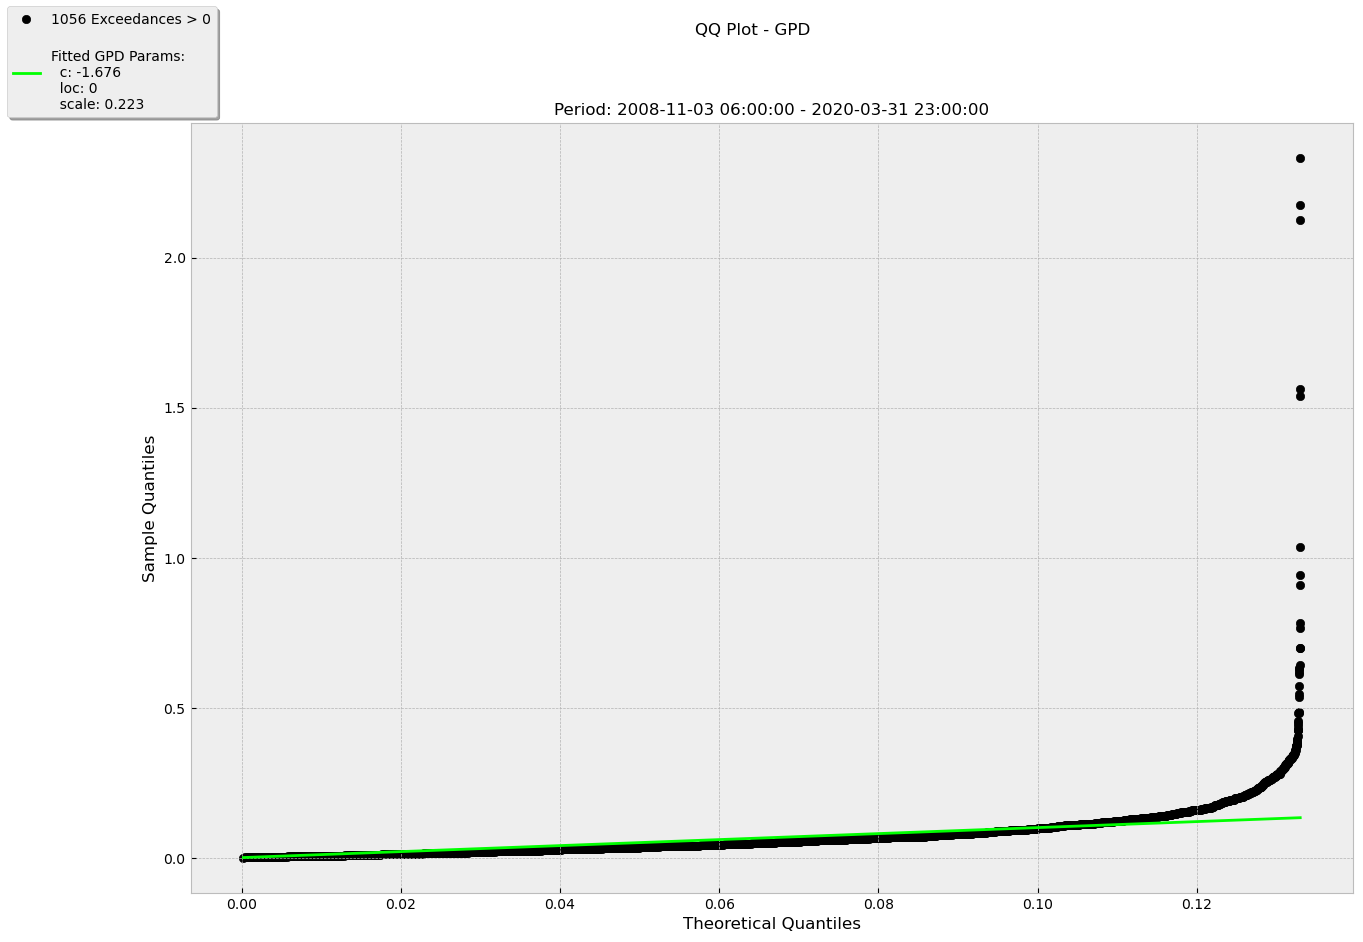

In [44]:
pot_detector.evaluate(method="qq")